In [222]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split, StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_selector, make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, MetaEstimatorMixin, clone
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, expon, loguniform
from scipy import stats
import joblib
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils.estimator_checks import check_estimator


# Fetch and Load the Data

In [2]:
def load_housing_data():
  tarball_path = Path("../Datasets/housing/housing.tgz")
  if not tarball_path.is_file():
    Path("../Datasets/housing").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="../Datasets/housing")
  return pd.read_csv(Path("../Datasets/housing/housing.csv"))

In [3]:
housing = load_housing_data()

In [4]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

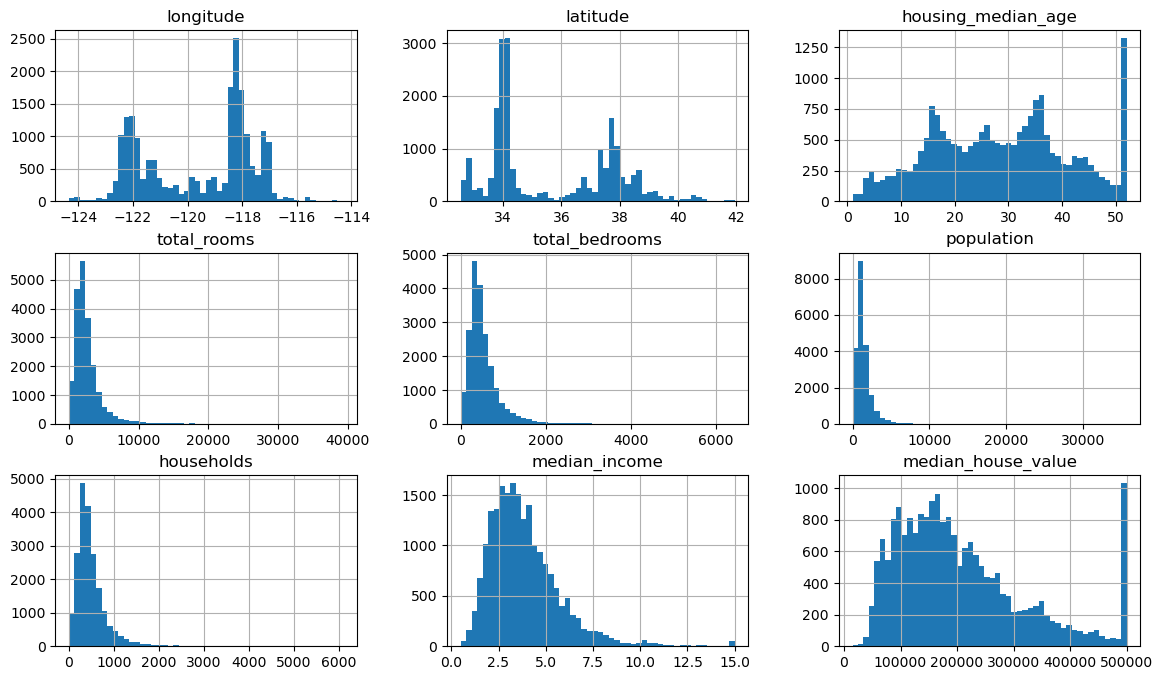

In [9]:
housing.hist(bins=50, figsize=(14, 8))

In [10]:
def shuffle_and_split_data(data, test_ratio):
  np.random.seed(42)
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices] 

In [11]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

In [12]:
len(train_set), len(test_set)

(16512, 4128)

In [13]:
train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700,229200.0,<1H OCEAN
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500,97800.0,INLAND
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344,222100.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN


In [14]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [15]:
train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700,229200.0,<1H OCEAN
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500,97800.0,INLAND
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344,222100.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN


In [16]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])

In [17]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,2
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,2
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,2


Text(0, 0.5, 'Number of districts')

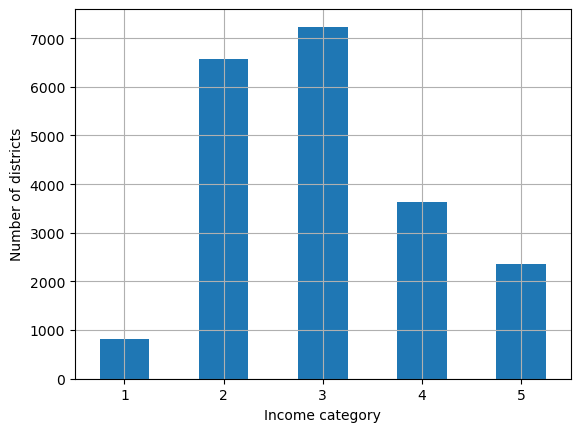

In [18]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")

In [19]:
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

In [20]:
strat_train_set, strat_test_set = strat_splits[0]

In [21]:
strat_train_set, strat_test_set = train_test_split(
  housing, test_size=0.2, stratify=housing["income_cat"],
  random_state=42
)

In [22]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [23]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

# Explore and Visualize the Data

In [24]:
housing = strat_train_set.copy()
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN


<Axes: xlabel='longitude', ylabel='latitude'>

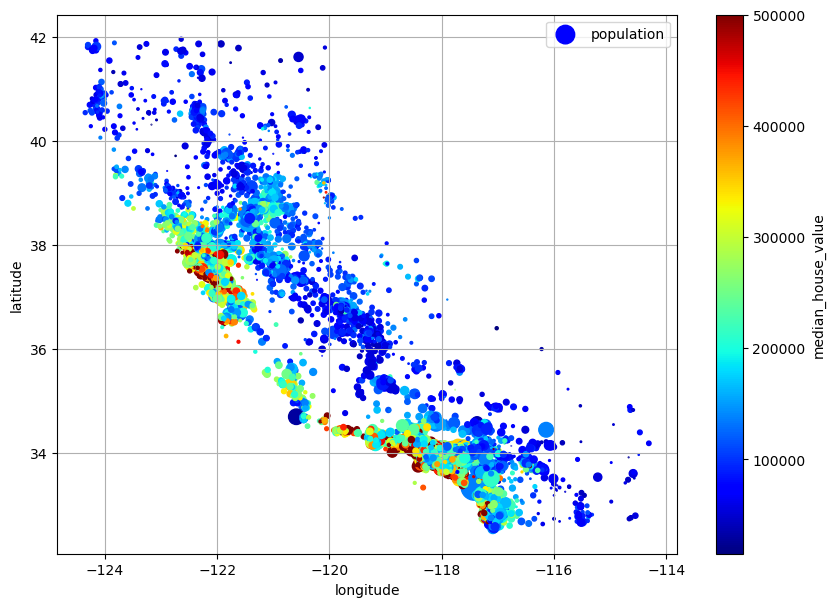

In [25]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
            s=housing["population"]/100, label="population",
            c="median_house_value", cmap="jet", figsize=(10, 7))

In [26]:
housing.drop("ocean_proximity", axis=1, inplace=True)
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0


In [27]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


In [28]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

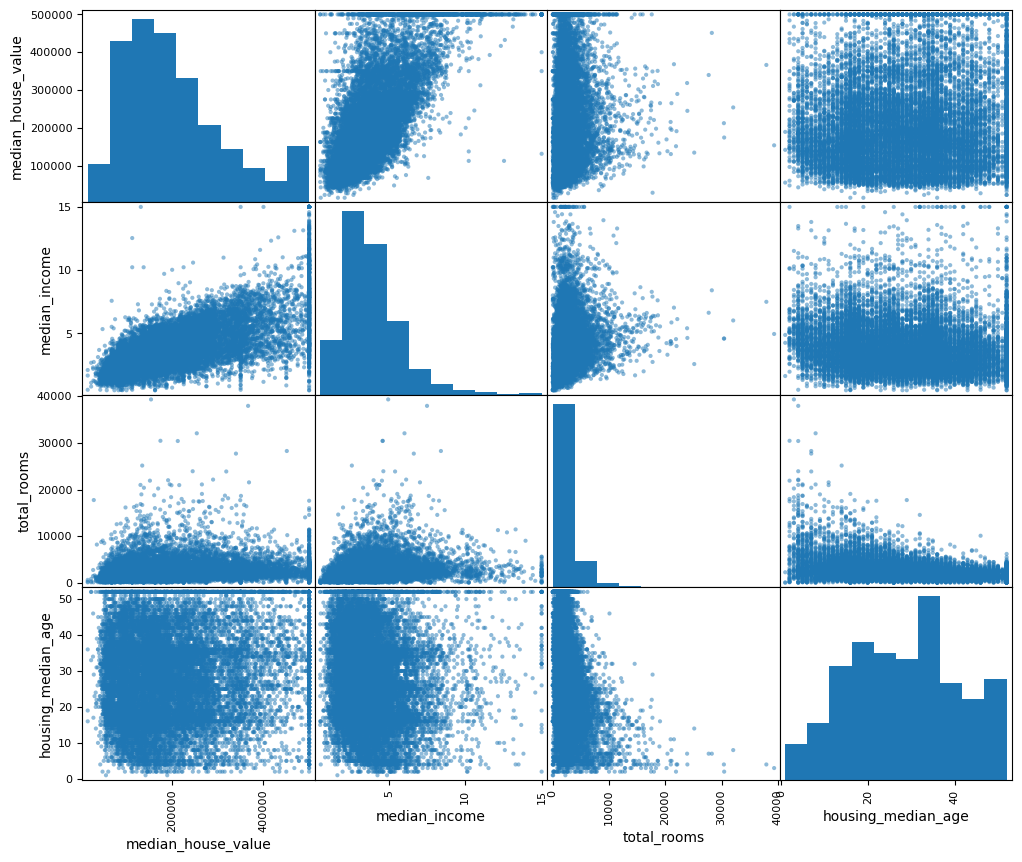

In [29]:
attributes = ["median_house_value", "median_income",
              "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 10))

<Axes: xlabel='median_income', ylabel='median_house_value'>

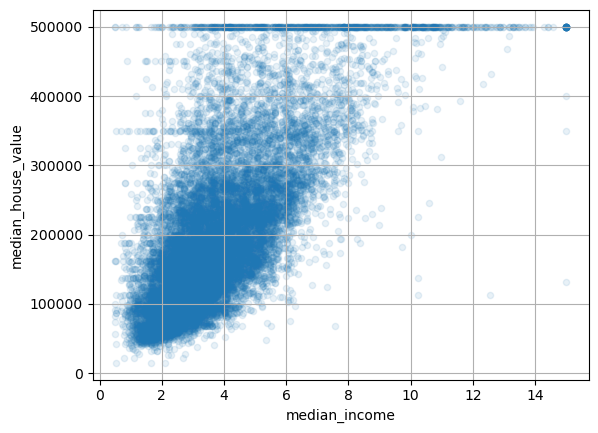

In [30]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
            grid=True, alpha=0.1)

In [31]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ration"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [32]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,bedrooms_ration,people_per_house
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,5.485836,0.205784,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,6.927083,0.160714,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,5.393333,0.191595,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,3.886128,0.276505,1.859213
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,6.096552,0.182692,3.167241
...,...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,6.658342,0.184696,2.023976
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,5.571932,0.179977,3.363188
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,4.110465,0.234795,2.662791
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,6.297405,0.183835,2.411178


In [33]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,bedrooms_ration,people_per_house
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466,-0.028374,0.095645,-0.000415
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673,0.107665,-0.116955,0.005426
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146,-0.147184,0.136768,0.015031
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140,0.127549,-0.192655,-0.024806
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781,0.000426,0.086883,-0.028364
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882,-0.074665,0.037736,0.076232
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590,-0.082971,0.067090,-0.027411
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151,0.311528,-0.624650,0.021815
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000,0.146255,-0.259952,-0.021991
rooms_per_house,-0.028374,0.107665,-0.147184,0.127549,0.000426,-0.074665,-0.082971,0.311528,0.146255,1.000000,-0.398529,-0.005316


In [34]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
rooms_per_house       0.146255
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
people_per_house     -0.021991
population           -0.026882
longitude            -0.047466
latitude             -0.142673
bedrooms_ration      -0.259952
Name: median_house_value, dtype: float64

# Prepare the Data for ML Algorithms

In [35]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [36]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN


In [37]:
housing_labels

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
           ...   
15174    268500.0
12661     90400.0
19263    140400.0
19140    258100.0
19773     62700.0
Name: median_house_value, Length: 16512, dtype: float64

In [38]:
housing.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN


In [39]:
housing.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,1837.0,580.0,4.4964,<1H OCEAN
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,2026.0,1001.0,5.0900,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,4769.0,1418.0,2.8139,INLAND
19263,-122.72,38.44,48.0,707.0,458.0,172.0,3.1797,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,1208.0,501.0,4.1964,<1H OCEAN


In [40]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)

12655     797.0
15502     855.0
2908      310.0
14053     519.0
20496     646.0
          ...  
15174    1231.0
12661    1422.0
19263     166.0
19140     580.0
19773     222.0
Name: total_bedrooms, Length: 16512, dtype: float64

In [41]:
imputer = SimpleImputer(strategy="median")

In [42]:
housing_num = housing.select_dtypes(include=[np.number])
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


In [43]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [44]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [45]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [46]:
X = imputer.transform(housing_num)

In [47]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                         index=housing_num.index)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


In [48]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [49]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [50]:
housing_cat_encoded[:8]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [51]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [52]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [53]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [54]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [55]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [56]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [57]:
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [58]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [59]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [60]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [61]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [62]:
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [63]:
housing_num_min_max_scaled

array([[-0.42430279,  0.27098831,  0.09803922, ..., -0.87477228,
        -0.73711725, -0.76914801],
       [ 0.41832669, -0.88310308, -0.76470588, ..., -0.88721657,
        -0.71396565, -0.19485248],
       [ 0.05776892, -0.39851222,  0.68627451, ..., -0.96277923,
        -0.88872293, -0.67240452],
       ...,
       [-0.6752988 ,  0.25398512,  0.84313725, ..., -0.9744948 ,
        -0.93651979, -0.63037751],
       [-0.67131474,  0.22635494, -0.49019608, ..., -0.93245326,
        -0.81366692, -0.49014496],
       [-0.55976096,  0.57917109,  0.01960784, ..., -0.96513355,
        -0.92718447, -0.63697052]])

In [64]:
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [65]:
housing_num_std_scaled

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.73260236,
         0.55628602, -0.8936472 ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.53361152,
         0.72131799,  1.292168  ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.67467519,
        -0.52440722, -0.52543365],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.86201341,
        -0.86511838, -0.36547546],
       [-1.56080303,  1.2492109 , -1.1653327 , ..., -0.18974707,
         0.01061579,  0.16826095],
       [-1.28105026,  2.02567448, -0.13148926, ..., -0.71232211,
        -0.79857323, -0.390569  ]])

In [66]:
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

In [67]:
age_simil_35

array([[2.73237224e-02],
       [8.93948745e-35],
       [3.03539138e-04],
       ...,
       [4.57533877e-08],
       [7.04065961e-20],
       [1.66155727e-03]])

In [68]:
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

In [69]:
scaled_labels

array([[-1.16601465],
       [ 0.62745084],
       [-1.07439665],
       ...,
       [-0.5756836 ],
       [ 0.44162188],
       [-1.2472608 ]])

In [70]:
model = LinearRegression()
model.fit(housing[["median_income"]],scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]

In [71]:
scaled_predictions = model.predict(some_new_data)

In [72]:
scaled_predictions

array([[-0.61407017],
       [ 0.88791396],
       [-0.36105202],
       [-0.59502347],
       [ 0.22384052]])

In [73]:
predictions = target_scaler.inverse_transform(scaled_predictions)

In [74]:
predictions

array([[135958.75805364],
       [309735.008975  ],
       [165232.3998617 ],
       [138162.41971241],
       [232903.1766333 ]])

In [75]:
model = TransformedTargetRegressor(LinearRegression(),
                                  transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [76]:
predictions

array([135958.75805364, 309735.008975  , 165232.3998617 , 138162.41971241,
       232903.1766333 ])

In [77]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [78]:
log_pop

,population
12655,7.712891
15502,7.608374
2908,6.502790
14053,6.800170
20496,7.515889
...,...
15174,7.613819
12661,8.469892
19263,6.126869
19140,7.096721


In [79]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [80]:
sf_coords = 37.7759, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                    kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [81]:
sf_simil

array([[0.86448746],
       [0.00760457],
       [0.18004914],
       ...,
       [0.94770417],
       [0.96373754],
       [0.61342487]])

In [82]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [83]:
class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, with_mean=True):
    self.with_mean = with_mean

  def fit(self, X, y=None):
    X = check_array(X)
    self.mean_ = X.mean(axis=0)
    self.scale_ = X.std(axis=0)
    self.n_features_in_ = X.shape[1]

    return self

  def transform(self, X):
    check_is_fitted(self)
    X = check_array(X)
    assert self.n_features_in_ == X.shape[1]
    if self.with_mean:
      X = X - self.mean_
    
    return X / self.scale_

In [84]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state

  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)

    return self

  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

  def get_feature_names_out(self, names=None):
    return [f"clsuter {i} similarity" for i in range(self.n_clusters)]

In [85]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                          sample_weight=housing_labels)

/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [86]:
similarities[:3].round(2)

array([[0.  , 0.31, 0.  , 0.85, 0.  , 0.  , 0.  , 0.  , 0.16, 0.49],
       [0.11, 0.  , 0.  , 0.  , 0.94, 0.  , 0.  , 0.41, 0.  , 0.  ],
       [0.11, 0.  , 0.15, 0.  , 0.  , 0.37, 0.  , 0.02, 0.  , 0.  ]])

In [87]:
num_pipeline = Pipeline([
  ("impute", SimpleImputer(strategy="median")),
  ("standardize", StandardScaler())
])

In [88]:
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [89]:
num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                            StandardScaler())

In [90]:
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [91]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-0.94,  1.35,  0.03,  0.58,  0.64,  0.73,  0.56, -0.89],
       [ 1.17, -1.19, -1.72,  1.26,  0.78,  0.53,  0.72,  1.29]])

In [92]:
df_housing_num_prepared = pd.DataFrame(
  housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
  index=housing_num.index
)

In [93]:
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752
...,...,...,...,...,...,...,...,...
15174,1.251711,-1.220505,-1.165333,1.890456,1.696862,0.543471,1.341519,0.637374
12661,-0.921368,1.342761,-1.085806,2.468471,2.161816,3.002174,2.451492,-0.557509
19263,-1.570794,1.310018,1.538566,-0.895802,-0.895679,-0.862013,-0.865118,-0.365475
19140,-1.560803,1.249211,-1.165333,0.249005,0.112126,-0.189747,0.010616,0.168261


In [94]:
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
              "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
  SimpleImputer(strategy="most_frequent"),
  OneHotEncoder(handle_unknown="ignore")
)

In [95]:
cat_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))])

In [96]:
preprocessing = ColumnTransformer([
  ("num", num_pipeline, num_attribs),
  ("cat", cat_pipeline, cat_attribs)
])

In [97]:
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['ocean_proximity'])])

In [98]:
preprocessing = make_column_transformer(
  (num_pipeline, make_column_selector(dtype_include=np.number)),
  (cat_pipeline, make_column_selector(dtype_include=object))
)

In [99]:
preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7faccb500760>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7faccb500ee0>)])

In [100]:
housing_prepared = preprocessing.fit_transform(housing)

In [101]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [102]:
preprocessing.get_feature_names_out()

array(['pipeline-1__longitude', 'pipeline-1__latitude',
       'pipeline-1__housing_median_age', 'pipeline-1__total_rooms',
       'pipeline-1__total_bedrooms', 'pipeline-1__population',
       'pipeline-1__households', 'pipeline-1__median_income',
       'pipeline-2__ocean_proximity_<1H OCEAN',
       'pipeline-2__ocean_proximity_INLAND',
       'pipeline-2__ocean_proximity_ISLAND',
       'pipeline-2__ocean_proximity_NEAR BAY',
       'pipeline-2__ocean_proximity_NEAR OCEAN'], dtype=object)

In [103]:
df_housing_prepared = pd.DataFrame(
  housing_prepared, columns=preprocessing.get_feature_names_out(),
  index=housing.index
)

In [104]:
df_housing_prepared

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.0,1.0,0.0,0.0,0.0
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.0,0.0,0.0,0.0,1.0
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,0.0,1.0,0.0,0.0,0.0
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,0.0,0.0,0.0,0.0,1.0
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,1.251711,-1.220505,-1.165333,1.890456,1.696862,0.543471,1.341519,0.637374,1.0,0.0,0.0,0.0,0.0
12661,-0.921368,1.342761,-1.085806,2.468471,2.161816,3.002174,2.451492,-0.557509,0.0,1.0,0.0,0.0,0.0
19263,-1.570794,1.310018,1.538566,-0.895802,-0.895679,-0.862013,-0.865118,-0.365475,1.0,0.0,0.0,0.0,0.0
19140,-1.560803,1.249211,-1.165333,0.249005,0.112126,-0.189747,0.010616,0.168261,1.0,0.0,0.0,0.0,0.0


In [105]:
def column_ratio(X):
  return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_name_in):
  return ["ratio"]

def ratio_pipeline():
  return make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(column_ratio, feature_names_out=ratio_name),
    StandardScaler()
  )

In [106]:
log_pipeline = make_pipeline(
  SimpleImputer(strategy="median"),
  FunctionTransformer(np.log, feature_names_out="one-to-one"),
  StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                    StandardScaler())

In [107]:
preprocessing = ColumnTransformer([
  ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
  ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
  ("people_per_house", ratio_pipeline(), ["population", "households"]),
  ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                        "households", "median_income"]),
  ("geo", cluster_simil, ["latitude", "longitude"]),
  ("cat", cat_pipeline, make_column_selector(dtype_include=object))
],
remainder=default_num_pipeline)

In [108]:
preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x7faccb48c1f0>,
                                                                      func=<function column_ratio...
                                 ['total_bedrooms', 'total_rooms', 'population',
                                  'households', 'median_income']),
                                ('geo', ClusterSimilarity(random_state=42),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7faccb48faf0>)])

In [109]:
housing_prepared = preprocessing.fit_transform(housing)

/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [110]:
housing_prepared.shape

(16512, 24)

In [111]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__clsuter 0 similarity',
       'geo__clsuter 1 similarity', 'geo__clsuter 2 similarity',
       'geo__clsuter 3 similarity', 'geo__clsuter 4 similarity',
       'geo__clsuter 5 similarity', 'geo__clsuter 6 similarity',
       'geo__clsuter 7 similarity', 'geo__clsuter 8 similarity',
       'geo__clsuter 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# Train and Evaluate on the Training Set

In [112]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fa...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faccb48faf0>)])),
                ('linearregression', LinearRegression())])

In [113]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

array([ 70700., 288200., 186000., 189700., 270700.])

In [114]:
housing_labels.iloc[:5].values

array([ 72100., 279600.,  82700., 112500., 238300.])

In [115]:
housing_predictions[:5].round(-2) - housing_labels.iloc[:5].values

array([ -1400.,   8600., 103300.,  77200.,  32400.])

In [116]:
lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                             squared=False)

In [117]:
lin_rmse

69239.95619019019

In [118]:
tree_reg = make_pipeline(preprocessing,
                        DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fa...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faccb48faf0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [119]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)

In [120]:
tree_rmse

0.0

In [121]:
housing_predictions[:5].round(-2)

array([ 72100., 279600.,  82700., 112500., 238300.])

In [122]:
housing_labels.iloc[:5].values

array([ 72100., 279600.,  82700., 112500., 238300.])

In [123]:
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)

/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

In [124]:
tree_rmses.round(2)

array([67450.1 , 68202.41, 62118.73, 64174.53, 63787.18, 69273.33,
       69091.09, 70659.66, 65425.34, 74127.49])

In [125]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     67430.987159
std       3623.038287
min      62118.730843
25%      64487.233745
50%      67826.258425
75%      69227.770860
max      74127.491554
dtype: float64

In [126]:
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)

/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

In [127]:
lin_rmses.round(2)

array([72967.27, 66097.14, 65132.89, 69567.41, 69959.86, 71174.67,
       93185.2 , 69585.19, 68176.98, 71129.16])

In [128]:
pd.Series(lin_rmses).describe()

count       10.000000
mean     71697.574921
std       7907.808501
min      65132.889557
25%      68524.583894
50%      69772.522175
75%      71163.289136
max      93185.203688
dtype: float64

In [129]:
forest_reg = make_pipeline(preprocessing,
                          RandomForestRegressor(random_state=42))
forest_reg.fit(housing, housing_labels)

/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fa...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faccb48faf0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [130]:
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)

In [131]:
forest_rmse

17611.944346777196

In [132]:
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                               scoring="neg_root_mean_squared_error", cv=10)

/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

In [133]:
forest_rmses.round(2)

array([49124.66, 46614.47, 43953.86, 48809.58, 44289.15, 48249.08,
       49674.55, 46583.64, 44835.46, 51153.38])

In [134]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47328.782275
std       2456.436091
min      43953.861521
25%      45272.501522
50%      47431.774424
75%      49045.891146
max      51153.378784
dtype: float64

# Fine-Tune the Model

In [135]:
full_pipeline = Pipeline([
  ("preprocessing", preprocessing),
  ("random_forest", RandomForestRegressor(random_state=42))
])

param_grid = [
  {'preprocessing__geo__n_clusters': [5, 8, 10],
  'random_forest__max_features': [4, 6, 8]},
  {'preprocessing__geo__n_clusters': [10, 15],
  'random_forest__max_features': [6, 8, 10]}
]

In [136]:
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                          scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7faccb48faf0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [137]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [138]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7faccb4...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faccc1f1af0>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [139]:
cv_res = pd.DataFrame(grid_search.cv_results_)

In [140]:
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

In [141]:
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,6.560721,0.063451,0.152715,0.000936,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43400.034636,-44475.145314,-45020.597845,-44298.592598,673.267864,1
13,8.430711,0.105284,0.163424,0.015783,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-43661.540847,-44477.925193,-45495.339385,-44544.935142,750.143106,2
14,10.378298,0.137960,0.152508,0.000852,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-44231.181354,-45166.951816,-46181.664914,-45193.266028,796.498947,3
7,6.488407,0.214870,0.162030,0.008920,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44437.056014,-45256.614625,-46451.673795,-45381.781478,827.212692,4
9,6.464179,0.095196,0.151296,0.001198,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44437.056014,-45256.614625,-46451.673795,-45381.781478,827.212692,4
6,4.582402,0.062491,0.164102,0.013699,10,4,"{'preprocessing__geo__n_clusters': 10, 'random...",-44518.465903,-45595.579538,-46299.265288,-45471.103576,732.317013,6
8,8.358943,0.139236,0.151758,0.000295,10,8,"{'preprocessing__geo__n_clusters': 10, 'random...",-44948.912484,-45459.746874,-46692.486999,-45700.382119,731.866114,7
10,8.560929,0.160265,0.153112,0.002262,10,8,"{'preprocessing__geo__n_clusters': 10, 'random...",-44948.912484,-45459.746874,-46692.486999,-45700.382119,731.866114,7
4,6.466276,0.118016,0.150095,0.000063,8,6,"{'preprocessing__geo__n_clusters': 8, 'random_...",-45173.262296,-45753.083557,-46996.906996,-45974.417616,760.772227,9
3,4.584220,0.038378,0.149990,0.000519,8,4,"{'preprocessing__geo__n_clusters': 8, 'random_...",-44953.590232,-45834.200925,-47536.384373,-46108.058510,1072.055619,10


In [142]:
param_distribs = {"preprocessing__geo__n_clusters": randint(low=3, high=50),
                 "random_forest__max_features": randint(low=2, high=20)}

In [143]:
rnd_search = RandomizedSearchCV(
  full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
  scoring="neg_root_mean_squared_error", random_state=42
)

rnd_search.fit(housing, housing_labels)

/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7faccb6f93a0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7faccb768160>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [144]:
rnd_search.best_params_

{'preprocessing__geo__n_clusters': 45, 'random_forest__max_features': 9}

In [145]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

In [146]:
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,9.664791,0.100094,0.157379,0.001218,45,9,"{'preprocessing__geo__n_clusters': 45, 'random...",-41481.854585,-42969.274287,-43230.304681,-42560.477851,770.110524,1
8,7.700438,0.050961,0.155567,0.000866,32,7,"{'preprocessing__geo__n_clusters': 32, 'random...",-41889.693046,-43529.122305,-43621.442208,-43013.419186,795.487720,2
5,4.996773,0.018306,0.153873,0.000843,42,4,"{'preprocessing__geo__n_clusters': 42, 'random...",-41954.672626,-44061.275973,-43504.594003,-43173.514201,891.311690,3
0,16.382256,0.096354,0.156003,0.000698,41,16,"{'preprocessing__geo__n_clusters': 41, 'random...",-42613.923189,-43528.391059,-44232.076545,-43458.130264,662.473902,4
2,8.504192,0.044044,0.152779,0.000545,23,8,"{'preprocessing__geo__n_clusters': 23, 'random...",-42880.310145,-43378.095398,-44482.955512,-43580.453685,669.741095,5
6,3.871616,0.027008,0.150867,0.000890,24,3,"{'preprocessing__geo__n_clusters': 24, 'random...",-42639.811500,-44471.661806,-44488.872874,-43866.782060,867.627655,6
7,13.330969,0.153825,0.152993,0.000213,26,13,"{'preprocessing__geo__n_clusters': 26, 'random...",-43242.783399,-43856.252510,-45114.993224,-44071.343044,779.311816,7
3,12.283291,0.114654,0.152271,0.000320,21,12,"{'preprocessing__geo__n_clusters': 21, 'random...",-43636.336440,-44306.596059,-45675.302003,-44539.411501,848.527122,8
4,5.540616,0.063136,0.159798,0.014025,13,5,"{'preprocessing__geo__n_clusters': 13, 'random...",-43855.517452,-44720.515684,-45192.666111,-44589.566416,553.686083,9
9,2.745199,0.033053,0.140287,0.000419,4,2,"{'preprocessing__geo__n_clusters': 4, 'random_...",-49329.847856,-51076.093264,-51489.714807,-50631.885309,936.036624,10


In [147]:
final_model = rnd_search.best_estimator_
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.18, 0.01, 0.02, 0.03,
       0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.  , 0.02, 0.02, 0.01, 0.02,
       0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.  , 0.03, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [148]:
sorted(zip(feature_importances,
          final_model["preprocessing"].get_feature_names_out()),
      reverse=True)

[(0.1813831690256434, 'log__median_income'),
 (0.08244502861607364, 'cat__ocean_proximity_INLAND'),
 (0.0718801580236537, 'bedrooms__ratio'),
 (0.05817301838233788, 'rooms_per_house__ratio'),
 (0.049517115363919215, 'people_per_house__ratio'),
 (0.03248219147637665, 'geo__clsuter 2 similarity'),
 (0.028221062269895562, 'geo__clsuter 43 similarity'),
 (0.022653278091252674, 'geo__clsuter 6 similarity'),
 (0.02198898088685375, 'geo__clsuter 15 similarity'),
 (0.021199799837403884, 'geo__clsuter 10 similarity'),
 (0.01773675216603871, 'geo__clsuter 11 similarity'),
 (0.016812078342102393, 'geo__clsuter 24 similarity'),
 (0.0166587519568679, 'geo__clsuter 13 similarity'),
 (0.015499668492902265, 'geo__clsuter 1 similarity'),
 (0.014115237838677923, 'geo__clsuter 23 similarity'),
 (0.01354873263940505, 'geo__clsuter 25 similarity'),
 (0.012858660059159845, 'geo__clsuter 0 similarity'),
 (0.012738526960538106, 'remainder__housing_median_age'),
 (0.012678159416906736, 'geo__clsuter 36 similar

In [149]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [150]:
final_predictions = final_model.predict(X_test)

In [151]:
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)

In [152]:
print(final_rmse)

39565.359517373756


In [153]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([37712.09234569, 41335.61948717])

# Lauch, Monitor, and Maintain the System

In [154]:
joblib.dump(final_model, "../Models/my_california_housing_model.pkl")

['../Models/my_california_housing_model.pkl']

In [155]:
final_model_reloaded = joblib.load("../Models/my_california_housing_model.pkl")

In [156]:
#predictions = final_model_reloaded.predict(new_data)

# Exercises

# 1

In [157]:
data = housing.iloc[:5000]
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
2972,-119.08,35.34,16.0,1535.0,238.0,768.0,236.0,5.4449,INLAND
9222,-120.43,36.99,16.0,1027.0,199.0,673.0,193.0,2.9688,INLAND
18715,-122.40,40.57,23.0,1321.0,259.0,749.0,222.0,1.6550,INLAND
15118,-116.95,32.84,31.0,1307.0,NaN,752.0,231.0,3.4286,<1H OCEAN


In [158]:
label = housing_labels[:5000]
label

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
           ...   
2972     118500.0
9222      63800.0
18715     90100.0
15118    129400.0
6114     133000.0
Name: median_house_value, Length: 5000, dtype: float64

In [159]:
full_pipeline = Pipeline([
  ("preprocessing", preprocessing),
  ("svr", SVR())
])

In [160]:
param_grid = [
  {"svr__kernel": ["linear"],
  "svr__C": [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
  {"svr__kernel": ["rbf"],
  "svr__C": [1.0, 3.0, 10., 30., 100., 300., 1000.0],
  "svr__gamma": [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
]

In [161]:
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                          scoring='neg_root_mean_squared_error')

In [162]:
grid_search.fit(data, label)

/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7faccb48faf0>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                     10000.0, 30000.0],
                          'svr__kernel': ['linear']},
                         {'svr__C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0,
                                     1000.0],
                          'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

In [163]:
-grid_search.best_score_

68800.46059326621

In [164]:
grid_search.best_params_

{'svr__C': 30000.0, 'svr__kernel': 'linear'}

# 2

In [165]:
param_distribs = {
  "svr__kernel": ["linear", "rbf"],
  "svr__C": loguniform(20, 200_000),
  "svr__gamma": expon(scale=1.0),
}

In [166]:
rnd_search = RandomizedSearchCV(
  full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
  scoring="neg_root_mean_squared_error", random_state=42, verbose=2
)

In [167]:
rnd_search.fit(data, label)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=629.7823295913721, svr__gamma=3.010121430917521, svr__kernel=linear; total time=   0.8s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=629.7823295913721, svr__gamma=3.010121430917521, svr__kernel=linear; total time=   0.9s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=629.7823295913721, svr__gamma=3.010121430917521, svr__kernel=linear; total time=   0.9s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=26290.20646430022, svr__gamma=0.9084469696321253, svr__kernel=rbf; total time=   1.3s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=26290.20646430022, svr__gamma=0.9084469696321253, svr__kernel=rbf; total time=   1.4s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=26290.20646430022, svr__gamma=0.9084469696321253, svr__kernel=rbf; total time=   1.3s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=84.14107900575871, svr__gamma=0.059838768608680676, svr__kernel=rbf; total time=   1.1s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=84.14107900575871, svr__gamma=0.059838768608680676, svr__kernel=rbf; total time=   1.2s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=84.14107900575871, svr__gamma=0.059838768608680676, svr__kernel=rbf; total time=   1.1s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=432.37884813148844, svr__gamma=0.15416196746656105, svr__kernel=linear; total time=   0.8s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=432.37884813148844, svr__gamma=0.15416196746656105, svr__kernel=linear; total time=   0.8s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=432.37884813148844, svr__gamma=0.15416196746656105, svr__kernel=linear; total time=   0.8s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=24.175082946113903, svr__gamma=3.503557475158312, svr__kernel=rbf; total time=   1.3s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=24.175082946113903, svr__gamma=3.503557475158312, svr__kernel=rbf; total time=   1.4s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=24.175082946113903, svr__gamma=3.503557475158312, svr__kernel=rbf; total time=   1.3s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=113564.03940586244, svr__gamma=0.0007790692366582295, svr__kernel=rbf; total time=   1.1s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=113564.03940586244, svr__gamma=0.0007790692366582295, svr__kernel=rbf; total time=   1.1s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=113564.03940586244, svr__gamma=0.0007790692366582295, svr__kernel=rbf; total time=   1.1s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=108.30488238805071, svr__gamma=0.3627537294604771, svr__kernel=rbf; total time=   1.1s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=108.30488238805071, svr__gamma=0.3627537294604771, svr__kernel=rbf; total time=   1.1s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=108.30488238805071, svr__gamma=0.3627537294604771, svr__kernel=rbf; total time=   1.1s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=21.34495367264743, svr__gamma=0.023332523598323388, svr__kernel=linear; total time=   0.8s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=21.34495367264743, svr__gamma=0.023332523598323388, svr__kernel=linear; total time=   0.8s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=21.34495367264743, svr__gamma=0.023332523598323388, svr__kernel=linear; total time=   0.8s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=5603.270317432522, svr__gamma=0.15023452872733867, svr__kernel=rbf; total time=   1.1s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=5603.270317432522, svr__gamma=0.15023452872733867, svr__kernel=rbf; total time=   1.2s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=5603.270317432522, svr__gamma=0.15023452872733867, svr__kernel=rbf; total time=   1.2s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=157055.10989448498, svr__gamma=0.26497040005002437, svr__kernel=rbf; total time=   2.8s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=157055.10989448498, svr__gamma=0.26497040005002437, svr__kernel=rbf; total time=   2.6s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[CV] END svr__C=157055.10989448498, svr__gamma=0.26497040005002437, svr__kernel=rbf; total time=   2.7s


/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7faccb48faf0>)])),
                                             ('svr', SVR())]),
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7faccb5fdb50>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7faccb3ebac0>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [168]:
-rnd_search.best_score_

55980.20600709426

In [169]:
rnd_search.best_params_

{'svr__C': 157055.10989448498,
 'svr__gamma': 0.26497040005002437,
 'svr__kernel': 'rbf'}

In [170]:
np.random.seed(42)
s = expon(scale=1).rvs(100_000)
((s > 0.105) & (s < 2.29)).sum() / 100_000

0.80066

# 3

In [187]:
new_pipeline = Pipeline([
  ("preprocessing", preprocessing),
  ("feature_selection", SelectFromModel(RandomForestRegressor(random_state=42),
                                       threshold=0.005)),
  ("svr", SVR(
    C=rnd_search.best_params_["svr__C"],
    gamma=rnd_search.best_params_["svr__gamma"],
    kernel=rnd_search.best_params_["svr__kernel"]
  ))
])

In [188]:
new_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7faccb4...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faccb48faf0>)])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=42),
                                 threshold=0.005)),
                ('svr', SVR(C=157055.10989448498, gamma=0.26497040005002437))])

In [189]:
selector_rmses = -cross_val_score(
  new_pipeline,
  data,
  label,
  scoring="neg_root_mean_squared_error",
  cv=3
)

/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kraiser/miniconda3/envs/DL/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [190]:
pd.Series(selector_rmses).describe()

count        3.000000
mean     55796.363048
std       2316.496343
min      54033.224103
25%      54484.564377
50%      54935.904651
75%      56677.932521
max      58419.960391
dtype: float64

# 4

In [221]:
class FeatureFromRegressor(MetaEstimatorMixin, BaseEstimator, TransformerMixin):
  def __init__(self, estimator):
    self.estimator = estimator

  def fit(self, X, y=None):
    estimator_ = clone(self.estimator)
    estimator_.fit(X, y)
    self.estimator_ = estimator_
    self.n_features_in_ = self.estimator_.n_features_in_
    if hasattr(self.estimator, "feature_names_in"):
      self.feature_names_in = self.estimator.feature_names_in_
    return self

  def transform(self, X):
    check_is_fitted(self)
    predictions = self.estimator_.predict(X)
    if predictions.ndim == 1:
      predictions = predictions.reshape(-1, 1)
    return predictions

  def get_feature_names_out(self, names=None):
    check_is_fitted(self)
    n_outputs = getattr(self.estimator_, "n_output_", 1)
    estimator_class_name = self.estimator_.__class__.__name__
    estimator_short_name = estimator_class_name.lower().replace("_", "")
    return [f"{estimator_short_name}_prediction_{i}" for i in range(n_outputs)]

In [223]:
check_estimator(FeatureFromRegressor(KNeighborsRegressor()))

In [224]:
knn_reg = KNeighborsRegressor(n_neighbors=3, weights="distance")
knn_transformer = FeatureFromRegressor(knn_reg)
geo_features = housing[["latitude", "longitude"]]
knn_transformer.fit_transform(geo_features, housing_labels)

array([[ 68850.],
       [279600.],
       [ 79000.],
       ...,
       [135700.],
       [258100.],
       [ 62700.]])

In [226]:
knn_transformer.get_feature_names_out()

['kneighborsregressor_prediction_0']